c:\Users\YIDAN\Desktop\projects\dysarthria-mtl-steal\venvs3prl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\YIDAN\Desktop\projects\dysarthria-mtl-steal\venvs3prl\lib\site-packages\transformers\configuration_utils.py:309: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Map: 100%|██████████| 27/27 [00:00<00:00, 95.07 examples/s]
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
Y

Linear(in_features=256, out_features=4, bias=True)


C:\Users\YIDAN\AppData\Local\Temp\ipykernel_11828\1743570077.py:120: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.391400,1.374944,0.380952
2,1.372800,1.354613,0.714286
3,1.331200,1.292353,0.571429
4,1.218700,1.183255,0.428571
5,1.085600,1.056747,0.380952
6,0.929100,1.010446,0.523810
7,0.750300,1.040932,0.428571
8,0.574600,1.082314,0.571429
9,0.422300,0.934873,0.619048
10,0.316500,0.885076,0.666667



✅ Final test accuracy: 0.6667


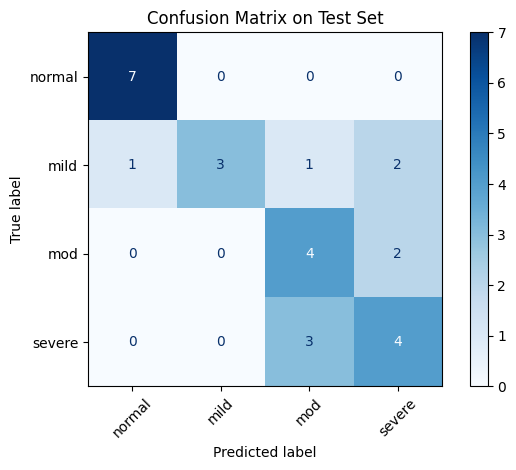

✅ Saved test predictions to test_predictions.csv
✅ Best metric value: 0.8850764036178589


In [1]:
import os
import torch
import pandas as pd
import torchaudio
from datasets import Dataset, DatasetDict
from transformers import (
    AutoFeatureExtractor,
    AutoModelForAudioClassification,
    TrainingArguments,
    Trainer,
)
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


# --- Load CSV ---
csv_path = r'C:\Users\YIDAN\Desktop\projects\dysarthria\dataset_youtube_pseudo_splits.csv'
df = pd.read_csv(csv_path)  
df["path"] = df["path"].apply(lambda p: p.replace("\\", "/"))

# --- Split into datasets ---
dataset_dict = DatasetDict({
    split: Dataset.from_pandas(df[df["split"] == split].reset_index(drop=True))
    for split in ["train", "valid", "test"]
})

# --- Label mapping ---
id2label = {
    0: "normal",
    1: "mild",
    2: "mod",
    3: "severe"
}
label2id = {v: k for k, v in id2label.items()}

# --- Load feature extractor ---
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")

# --- Preprocessing (Manual audio loading) ---
target_sr = feature_extractor.sampling_rate  # Should be 16000

def preprocess_function(examples):
    # List of file paths
    paths = examples["path"]

    # Load all waveforms and resample if needed
    waveforms = []
    for path in paths:
        waveform, sr = torchaudio.load(path)
        if sr != feature_extractor.sampling_rate:
            resampler = torchaudio.transforms.Resample(sr, feature_extractor.sampling_rate)
            waveform = resampler(waveform)
        waveform = waveform.mean(dim=0)  # Convert to mono
        waveforms.append(waveform.numpy())

    # Use feature extractor to pad/truncate batch
    inputs = feature_extractor(
        waveforms,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=48000,  # 3 seconds at 16kHz
        truncation=True,
        padding="max_length",
    )

    # Add labels
    inputs["label"] = examples["category"]

    return inputs

# --- Map preprocessing ---
encoded_ds = dataset_dict.map(preprocess_function,batched = True, remove_columns=["name", "path", "category", "split"])
# print(encoded_ds["train"][0])

# --- Load model ---
num_labels = len(id2label)
model = AutoModelForAudioClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label
)

print(model.classifier)

# --- Metric ---
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(pred.label_ids, preds)
    return {"accuracy": acc}

# --- Training setup ---
ts = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_name = f"tuned_wav2vec2_{ts}"

for param in model.wav2vec2.parameters():
    param.requires_grad = True

training_args = TrainingArguments(
    output_dir=f"./models_frozenbase/{model_name}",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1, 
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=30,
    gradient_accumulation_steps=1,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model = "eval_loss",
    greater_is_better = False,
    push_to_hub=False,
    logging_dir="./logs_wav2vec",  # Directory for storing logs
    logging_strategy="epoch",
)

# --- Trainer ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_ds["train"],
    eval_dataset=encoded_ds["valid"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

# --- Train ---
trainer.train()

# --- Evaluate on test set ---
test_results = trainer.evaluate(encoded_ds["test"])
print(f"\n✅ Final test accuracy: {test_results['eval_accuracy']:.4f}")

# --- Get predictions ---
preds_output = trainer.predict(encoded_ds["test"])
preds = np.argmax(preds_output.predictions, axis=1)
labels = preds_output.label_ids

# --- Compute confusion matrix ---
cm = confusion_matrix(labels, preds, labels=[0, 1, 2, 3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["normal", "mild", "mod", "severe"])

# --- Plot ---
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()

# --- Get original test data (with paths & names) ---
df_test = df[df["split"] == "test"].reset_index(drop=True)
df_test["predicted_score"] = preds
# --- Optional: Map back to label names ---
df_test["predicted_label"] = df_test["predicted_score"].map(id2label)
df_test["true_label"] = df_test["category"].map(id2label)
# --- Save to CSV ---
df_test.to_csv("wav2vec_test_predictions.csv", index=False)
print("✅ Saved test predictions to test_predictions.csv")

# ---Save train/val curves ---
# Convert log history to DataFrame
logs = pd.DataFrame(trainer.state.log_history)
train_logs = logs[logs["loss"].notnull()] # Filter for train and eval logs
eval_logs = logs[logs["eval_loss"].notnull()]
plt.figure(figsize=(10, 4)) # --- Plot & Save Loss Curve ---
plt.plot(train_logs["epoch"], train_logs["loss"], label="Train Loss", marker='o')
plt.plot(eval_logs["epoch"], eval_logs["eval_loss"], label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_curve.png")
plt.close() 
if "eval_accuracy" in eval_logs: # --- Plot & Save Accuracy Curve ---
    plt.figure(figsize=(10, 4))
    plt.plot(eval_logs["epoch"], eval_logs["eval_accuracy"], label="Validation Accuracy", marker='o', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Validation Accuracy Curve")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("accuracy_curve.png")
    plt.close()

# print(f"✅ Best model was from step: {trainer.state.best_step}")
print(f"✅ Best metric value: {trainer.state.best_metric}")